In [14]:
import json
import pandas as pd
import os

# needed for Kaggle
import sys
PATH_TO_CODE = '/kaggle/input/russian-slr-code'
sys.path.insert(0, PATH_TO_CODE)
subfolders = [f.path for f in os.scandir(PATH_TO_CODE) if f.is_dir()]
for subfolder in subfolders:
    sys.path.insert(0, subfolder)

LANDMARKS_PATH = '/kaggle/input/landmarks-of-slovo-dataset/slovo_mediapipe.json'
ANNOT_PATH = '/kaggle/input/russian-slr/slovo_annotations/slovo_annotations/SLOVO_DATAFRAME.tsv'

with open(LANDMARKS_PATH) as f:
    data = json.load(f)

annot = pd.read_table(ANNOT_PATH)

In [4]:
!pip install -q mediapipe

In [15]:
from data.data_utils import get_frames
from utils.visualization import draw_landm_points

# get video_file landmarks
video_file = '58a528b5-8517-42bb-a74c-520caa220831'
video_path = f'/kaggle/input/russian-slr/slovo/slovo/{video_file}.mp4'
frames = get_frames(video_path)
ann = annot[annot['attachment_id']==video_file].iloc[0]
sign_frames = frames[ann['begin']:ann['end']]

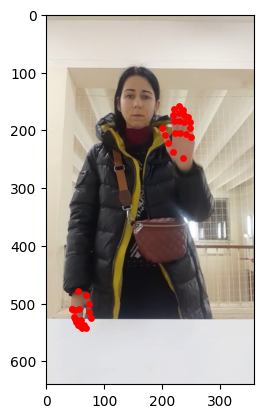

In [16]:
# draw landmarks on frame
frame_num = 2
draw_landm_points(sign_frames[frame_num], data[video_file][frame_num])

In [17]:
# labels for training
labels = ['Привет!', 'Пока', 'Я', 'тебя', 'любить']
label_encoding = {label:i for i, label in enumerate(labels)}
inv_lbl_encoding = {value:key for key, value in label_encoding.items()}
label_encoding

{'Привет!': 0, 'Пока': 1, 'Я': 2, 'тебя': 3, 'любить': 4}

In [18]:
from data.data_utils import LandmarksDataset

# all filenames for chosen labels
filenames = [annot[annot['text']==lbl]['attachment_id'].values for lbl in labels]
# flatten the list of lists
filenames = [item for sublist in filenames for item in sublist]
# landmarks dict
landmarks = {filename:data[filename] for filename in filenames}

# num frames in each video
seq_len = 32
dataset = LandmarksDataset(landmarks, filenames, annot, label_encoding, seq_len)

In [19]:
from sklearn.model_selection import train_test_split
import torch

train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset.labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)